<a href="https://colab.research.google.com/github/jdasam/ant5015/blob/main/notebooks/9th_week_source_separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scaper
!pip install nussl
!pip install git+https://github.com/source-separation/tutorial


In [ ]:
from IPython.display import Audio, display
import matplotlib.pyplot as plt

In [ ]:
from common import data, viz
import nussl
# Prepare MUSDB
data.prepare_musdb('~/.nussl/tutorial/')


In [ ]:
stft_params = nussl.STFTParams(window_length=512, hop_length=128, window_type='sqrt_hann')
fg_path = "~/.nussl/tutorial/train"
train_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=1000, coherent_prob=1.0)


In [ ]:
item = train_data[0]
viz.show_sources(item['sources'])


In [ ]:
item['sources']['bass'].audio_data

In [ ]:
import numpy as np

item = train_data[1]

spec = item['sources']['bass'].stft()
mag_spec = np.abs(spec)
phase_spec = np.angle(item['mix'].stft())

mag_spec = mag_spec * np.exp(1j * phase_spec)
mag_istft = item['sources']['bass'].make_copy_with_stft_data(mag_spec).istft()

In [ ]:
plt.imshow((phase_spec[..., 0]), origin='lower', aspect='auto', )

In [ ]:
Audio(item['sources']['bass'].audio_data, rate=44100)

In [ ]:
Audio(mag_istft, rate=44100)

In [ ]:
?nussl.core.audio_signal.AudioSignal

In [ ]:
Audio(item['sources']['drums'].audio_data, rate=44100)

# 1. Load Dataset

In [ ]:
musdb_train = nussl.datasets.MUSDB18(subsets='train', split="train")
musdb_valid = nussl.datasets.MUSDB18(subsets='train', split="valid")
musdb_test = nussl.datasets.MUSDB18(subsets='test')
len(musdb_train), len(musdb_valid), len(musdb_test)

In [ ]:
train_item = musdb_train[1]

In [ ]:
train_item['mix'].audio_data

In [ ]:
train_item['sources']['vocals'].audio_data

In [ ]:
display(Audio(train_item['mix'].audio_data[:, :200000], rate=44100))

In [ ]:
duration = 5

dataset_path = "~/.nussl/tutorial/"

trainset = data.on_the_fly(stft_params, transform=None, fg_path=dataset_path+"/train", num_mixtures=10000, duration=duration)
item = trainset[200]


In [ ]:
display(Audio(item['mix'].audio_data[:, :200000], rate=44100))

### Transform Data
- We have to transform nussl.core.AudioSignal into desired format
    1. We want to make One Vs All separation system. Therefore, we have to combine the sources except target
        - If you want to make vocal separator, you can mix drum, bass, and other as a single source
        - If you want to make drum separator, you can mix vocal, bass, and other as a single source
    2. We want to use spectrogram instead of waveform audio samples


In [ ]:
from nussl.datasets import transforms as nussl_tfm

item = trainset[0]
sum_sources = nussl_tfm.SumSources([['bass', 'drums', 'other']])
transformed_item = sum_sources(item)
print(transformed_item['sources'])


In [ ]:
Audio(transformed_item['sources']['bass+drums+other'].audio_data,rate=44100)

In [ ]:
# Make Magnitude Spectrogram np.abs(AudioSignal.stft())
msa = nussl_tfm.MagnitudeSpectrumApproximation()

item = trainset[0]

transformed_item = msa(item)
print(transformed_item.keys())
print(transformed_item['source_magnitudes'].shape)

plt.figure(figsize=(10,20))
plt.subplot(4,1,1)
plt.imshow(np.log10(transformed_item['source_magnitudes'][...,0]), origin='lower', aspect='auto')
plt.subplot(4,1,2)
plt.imshow(np.log10(transformed_item['source_magnitudes'][...,1]), origin='lower', aspect='auto')
plt.subplot(4,1,3)
plt.imshow(np.log10(transformed_item['source_magnitudes'][...,2]), origin='lower', aspect='auto')
plt.subplot(4,1,4)
plt.imshow(np.log10(transformed_item['source_magnitudes'][...,3]), origin='lower', aspect='auto')

In [ ]:
transformed_item['sources']

In [ ]:
tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])
item = trainset[0]
print("Before transforms")
for key in item:
    print(key, type(item[key]))
print("\nAfter transforms")
item = tfm(item)
for key in item:
    print(key, type(item[key]))

In [ ]:
plt.imshow(item['ideal_binary_mask'][:,:,0,1].T, origin='lower', aspect='auto')

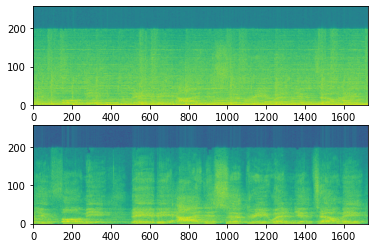

In [87]:
plt.subplot(2,1,1)
plt.imshow(item['mix_magnitude'][:,:,0].log().T, aspect='auto', origin='lower')
plt.subplot(2,1,2)
plt.imshow(item['source_magnitudes'][:,:,0,0].log().T, aspect='auto', origin='lower')


In [ ]:
stft_params = nussl.STFTParams(window_length=512, hop_length=128, window_type='sqrt_hann')
tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])
duration = 5
trainset = data.on_the_fly(stft_params,
                          transform=tfm,
                          fg_path=dataset_path+"/train",
                          num_mixtures=10000000,
                          time_stretch=None,
                          duration=duration)
item = trainset[0]
print(item.keys())

In [86]:
import torch

train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

batch = next(iter(train_loader))
batch['mix_magnitude'].shape

torch.Size([4, 1724, 257, 1])

In [90]:
batch['mix_magnitude'].dtype

torch.float64

In [92]:
# normalization

norm_layer = torch.nn.BatchNorm1d(257)
normed_batch = norm_layer(batch['mix_magnitude'].to(torch.float32).squeeze().transpose(1,2))


tensor([[[-5.1011e-01, -1.2149e-01,  1.0920e+00,  ..., -2.2582e-01,
           2.8202e-01, -4.2506e-01],
         [-9.9041e-01, -2.8019e-01,  6.9842e-01,  ..., -1.3244e-01,
          -5.2420e-01, -9.6042e-01],
         [-1.1468e+00, -1.0391e+00,  5.8954e-01,  ..., -9.9618e-01,
          -9.0991e-01, -1.2026e+00],
         ...,
         [ 2.7711e-04,  3.9186e-04, -1.5646e-04,  ...,  1.4478e-04,
          -6.2120e-05, -8.2965e-05],
         [ 5.4188e-04,  2.3576e-04, -1.5690e-04,  ...,  1.7246e-04,
          -1.7712e-04, -1.1463e-04],
         [ 2.7182e-04,  3.7329e-05, -1.4719e-04,  ...,  1.9159e-04,
          -4.1571e-05, -2.0644e-04]],

        [[-7.8894e-01, -1.3626e-02,  2.2554e-01,  ..., -5.0485e-01,
          -7.8601e-01, -8.0854e-01],
         [-1.1268e+00, -5.4296e-01, -2.2790e-02,  ..., -8.3779e-01,
          -1.1071e+00, -1.2212e+00],
         [-1.2844e+00, -1.0196e+00, -2.3391e-01,  ..., -9.7480e-01,
          -1.2511e+00, -1.4457e+00],
         ...,
         [-1.5530e-04,  2

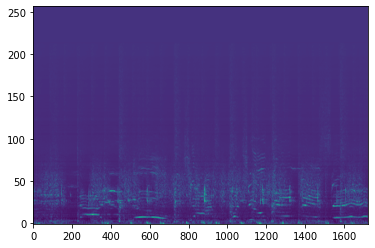

In [98]:
plt.imshow(normed_batch[0].detach(), aspect='auto', origin='lower')

In [128]:
masked_mix = batch['mix_magnitude'][0]  * batch['ideal_binary_mask'][0,:,:,:,1] 
original_source = batch['source_magnitudes'][0, :, :,:, 0]
torch.allclose(masked_mix, original_source, atol=1e-2)

False

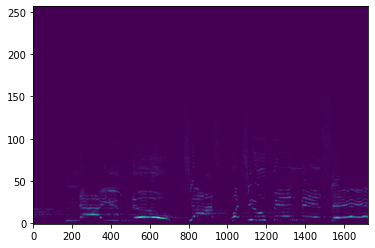

In [125]:
plt.imshow(masked_mix.squeeze().T, aspect='auto', origin='lower')

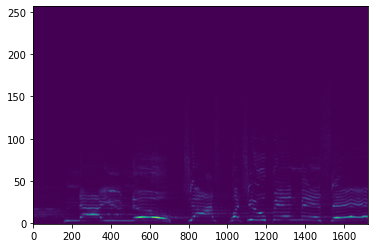

In [126]:
plt.imshow(original_source.squeeze().T, aspect='auto', origin='lower')

In [136]:
import torch.nn as nn
# import torchaudio

class Separator(nn.Module):
  def __init__(self, hidden_size=256, num_freq_bin=257):
    super().__init__()

    # self.amp_to_db = torchaudio.transforms.AmplitudeToDB()
    self.spec_norm = nn.BatchNorm1d(num_freq_bin)

    self.gru = nn.GRU(input_size=num_freq_bin, hidden_size=hidden_size, num_layers=2, batch_first=True, bidirectional=True)

    self.linear = nn.Linear(hidden_size, num_freq_bin)

  def amp_to_db(self, spec, min_value=-80.0):
    return torch.clamp(10 * torch.log10(spec), min=min_value)
  
  def forward(self, mag_spec):
    mag_spec = mag_spec.squeeze()
    db_spec = self.amp_to_db(mag_spec).to(torch.float32) # N x T x C 
    db_spec = self.spec_norm(db_spec.permute(0,2,1)) # N x C x T

    # RNN takes N x T x C (or T x N x C if batch_first=False)
    db_spec = db_spec.permute(0,2,1)
    hidden_out, last_hidden = self.gru(db_spec)
    # last_hidden.shape = (num_layers * num_direction) x N x H

    print(hidden_out.shape, last_hidden.shape)
    return hidden_out


model = Separator()
model(batch['mix_magnitude'])

torch.Size([4, 1724, 512]) torch.Size([4, 4, 256])


tensor([[[-4.5653e-02, -1.0713e-01,  2.4059e-01,  ..., -2.7733e-01,
           2.7913e-01, -2.6645e-01],
         [-1.6237e-01, -1.2509e-01,  3.7937e-01,  ..., -1.5530e-01,
           2.6778e-01, -3.4263e-01],
         [-2.9361e-01, -1.1572e-01,  3.3161e-01,  ..., -1.1721e-01,
           2.5248e-01, -2.9053e-01],
         ...,
         [ 1.7133e-01, -7.9526e-01,  6.9427e-02,  ..., -4.3717e-01,
           1.1592e-01, -5.5727e-02],
         [ 1.4367e-01, -7.5509e-01,  1.6800e-01,  ..., -4.3137e-01,
           4.0118e-02, -1.5993e-01],
         [ 4.3359e-02, -5.4085e-01,  4.1128e-01,  ..., -3.0817e-01,
          -2.4516e-02, -1.8535e-01]],

        [[ 9.7638e-02, -6.2705e-02, -9.1904e-02,  ..., -2.2120e-02,
          -8.0222e-02,  3.1312e-02],
         [ 3.0311e-01, -2.8808e-01, -1.2554e-01,  ...,  1.5475e-01,
          -8.8720e-02,  6.9136e-02],
         [ 4.0173e-01, -4.3585e-01, -1.8356e-01,  ...,  1.8854e-01,
          -1.4547e-01,  9.2903e-02],
         ...,
         [ 3.1090e-01, -7